In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import models, transforms, utils
from PIL import Image
from torch.optim import Adam

In [5]:
class MelaData(Dataset):
    """MelaData dataset."""

    def __init__(self, data_dir, label_csv, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with labels.
            data_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample: use prep1
        """
        
        self.data_dir = data_dir
        self.files = os.listdir(data_dir)
        
        labels = pd.read_csv(label_csv)
        dx_to_num = {'nv' : 0, 'mel': 1, 'bkl': 2, 'df': 3, 'akiec': 4, 'bcc': 5, 'vasc' : 6}        
        labels['label'] = labels['dx'].apply(lambda x: dx_to_num[x])
        self.labels = labels
        
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image_name_with_extension = self.files[idx]
        image = Image.open(data_dir + image_name_with_extension)
        image_name = image_name_with_extension.strip('.jpg')
        
        if self.transform:
            image = self.transform(image)    
            
        label = self.labels.loc[self.labels['image_id'] == image_name, 'label']
        label = np.array(label)
        label_t = torch.from_numpy(label)
        return {'image': image, 'label': label_t}

In [6]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

prep1 = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
            ])

In [7]:
#Load a dataset
data_dir = 'data/images/train/'# Image File
label_csv = 'data/HAM10000_metadata.csv'
small_data = MelaData(data_dir=data_dir, label_csv=label_csv, transform=prep1)

In [8]:
#Helper function to show image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

<Figure size 432x288 with 0 Axes>

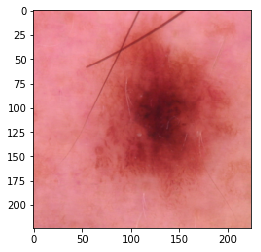

In [11]:
plt.figure()
imshow(small_data[1]['image'])
plt.show()

In [12]:
dataloader = DataLoader(small_data, batch_size=4,
                        shuffle=True, num_workers=4)

0 torch.Size([4, 3, 224, 224])
1 torch.Size([4, 3, 224, 224])


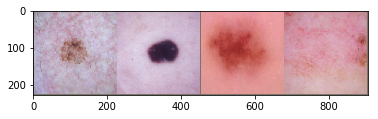

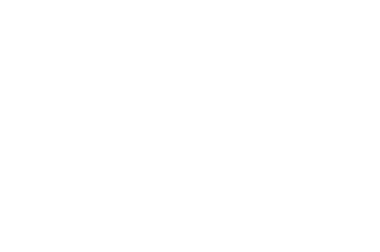

In [15]:
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch = sample_batched['image']
    batch_size = len(images_batch)
    im_size = images_batch.size

    grid = utils.make_grid(images_batch)
    imshow(grid)

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size())

    # observe 4th batch and stop.
    if i_batch == 1:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break


In [17]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

dtype = torch.FloatTensor
if use_gpu:
    dtype = torch.cuda.FloatTensor

Using gpu: False 


### Using vgg16

In [18]:
num_classes = 7

In [19]:
vgg = models.vgg16(pretrained=True)
if use_gpu:
    model_vgg = model_vgg.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/robinali/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [06:58<00:00, 1322616.32it/s] 


In [20]:
# Freeze training for all layers
for param in vgg.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg.classifier[6].in_features
features = list(vgg.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, num_classes)]) #
vgg.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [21]:
print(features)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace), Dropout(p=0.5), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace), Dropout(p=0.5), Linear(in_features=4096, out_features=7, bias=True)]


In [22]:
vgg.classifier[6]

Linear(in_features=4096, out_features=7, bias=True)

In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import models, transforms, utils
from PIL import Image
from tqdm import tqdm, tqdm_notebook
from torch.optim import Adam


class vgg_preloaded(nn.Module):

    def __init__(self, num_class, cuda):
        super(vgg_preloaded, self).__init__()
        self.cuda = cuda
        self.num_class = num_class
        self.dtype = torch.cuda.FloatTensor if self.cuda else torch.FloatTensor
        model = models.vgg16(pretrained=True)
        self.model = model.cuda() if self.cuda else model
        for param in self.model.features.parameters():
            param.require_grad = False
        num_features = self.model.classifier[6].in_features
        features = list(self.model.classifier.children())[:-1] # Remove last layer
        features.extend([nn.Linear(num_features, self.num_class)])
        self.model.classifier = nn.Sequential(*features)
        self.model.classifier.require_grad = True

    def forward(self, inp):
        return(self.model(inp))

#----------------------------------------------------
# Below is the data loader
#----------------------------------------------------


class MelaData(Dataset):
    """MelaData dataset."""

    def __init__(self, data_dir, label_csv, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with labels.
            data_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample: use prep1
        """

        self.data_dir = data_dir
        self.files = os.listdir(data_dir)

        labels = pd.read_csv(label_csv)
        dx_to_num = {'nv' : 0, 'mel': 1, 'bkl': 2, 'df': 3, 'akiec': 4, 'bcc': 5, 'vasc' : 6}        
        labels['label'] = labels['dx'].apply(lambda x: dx_to_num[x])
        self.labels = labels

        if transform is None:
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            transform = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ColorJitter(hue=.05, saturation=.05),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(360, resample=Image.BILINEAR),
                transforms.ToTensor(),
                normalize,
                ])


        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image_name_with_extension = self.files[idx]
        image = Image.open(data_dir + image_name_with_extension)
        image_name = image_name_with_extension.strip('.jpg')

        if self.transform:
            image = self.transform(image)    

        label = self.labels.loc[self.labels['image_id'] == image_name, 'label']
        label = np.array(label)
        label_t = torch.from_numpy(label)[0]
        return(image, label_t)


#----------------------------------------------------
# Below is the train function
#----------------------------------------------------



def train(data_dir, label_dir, save_dir,  epoch, mb, num_class, cuda, name = 'model', num_workers = 1, conti = False, lr = 1e-3, save = True):
    # instantiate the vgg model
    model = vgg_preloaded(num_class, cuda)

    # if dir does not exit, make it:
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    # define model path
    modelpath = os.path.join(save_dir, '{}.pt'.format(name))

    # do we wanna continue to train
    if os.path.isfile(modelpath) and conti:
        model.load_state_dict(torch.load(modelpath))
    if cuda:
        model = model.cuda()
    model.train()

    loss_train = np.zeros(epoch)
    acc_train = np.zeros(epoch)
    loss_fun = torch.nn.CrossEntropyLoss(reduction = 'sum')
    optim = Adam(model.parameters(), lr = lr)

    for epoch_num in range(1, epoch+1):
        running_loss = 0.0
        running_corrects = 0.0
        size = 0

        dataset = MelaData(data_dir = data_dir, label_csv = label_dir)
        dataloader = DataLoader(dataset, batch_size = mb, shuffle = True, num_workers = num_workers)

        pbar = tqdm_notebook(dataloader)
        pbar.set_description("[Epoch {}]".format(epoch_num))
        for inputs, labels in pbar:
            bs = labels.size(0)
            if cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            output = model(inputs)
            _, preds = torch.max(output.data, 1)
            loss = loss_fun(output, labels)
            running_loss += loss
            running_corrects += preds.eq(labels.view_as(preds)).sum()
            optim.zero_grad()
            loss.backward()
            optim.step()
            size += bs

        epoch_loss = running_loss / size
        epoch_acc = running_corrects.item() / size
        loss_train[epoch_num-1] = epoch_loss
        acc_train[epoch_num-1] = epoch_acc
        print('Train - Loss: {:.4F} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    if save:
        torch.save(model.state_dict(), os.path.join(save_dir, '{}.pt'.format(name)))
        torch.save(optim.state_dict(), os.path.join(save_dir, '{}.optim.pt'.format(name)))
    return(loss_train, acc_train)

#----------------------------------------------------
# Below is the eval function
#----------------------------------------------------



In [4]:
train(data_dir, label_csv, save_dir=save_dir, epoch=2, mb=4, num_class=7, cuda=False, name = 'model',
      num_workers = 1, conti = False, lr = 1e-3, save = True)

A Jupyter Widget


Train - Loss: 1.8044 Acc: 0.6000


A Jupyter Widget


Train - Loss: 5.4359 Acc: 0.6667


(array([1.8043648 , 5.43589067]), array([0.6       , 0.66666667]))

In [3]:
data_dir = '/Users/clementponsonnet/Desktop/Important/HEC/Cours/DeepLearning/project/skin-cancer-mnist-ham10000/small_data/'
label_csv = '/Users/clementponsonnet/Desktop/Important/HEC/Cours/DeepLearning/project/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'
save_dir = '/Users/clementponsonnet/Desktop/Important/HEC/Cours/DeepLearning/project/skin-cancer-mnist-ham10000/saved_output.txt'

#small_data = MelaData(data_dir=data_dir, label_csv=label_csv)


In [7]:
model = torch.load('/Users/clementponsonnet/Desktop/Important/HEC/Cours/DeepLearning/project/skin-cancer-mnist-ham10000/saved_output.txt/model.pt')

In [6]:
!pwd

/Users/clementponsonnet/Desktop/Important/HEC/Cours/DeepLearning/project


In [11]:
model

OrderedDict([('model.features.0.weight', tensor([[[[-0.5517,  0.1441,  0.5303],
                        [-0.5809,  0.3582,  0.7668],
                        [-0.6879, -0.0461,  0.4854]],
              
                       [[ 0.1737,  0.0083, -0.0829],
                        [ 0.0423, -0.0720, -0.2618],
                        [ 0.1308, -0.1744, -0.1338]],
              
                       [[ 0.3113, -0.1676, -0.4291],
                        [ 0.4734, -0.0844, -0.4886],
                        [ 0.6303,  0.0175, -0.2793]]],
              
              
                      [[[ 0.2307,  0.1247,  0.1840],
                        [-0.4298, -0.2454,  0.2442],
                        [-0.2526,  0.1398, -0.0076]],
              
                       [[-0.1451, -0.2238,  0.1452],
                        [-0.8460, -0.3568,  0.5586],
                        [-0.2471,  0.5139,  0.5336]],
              
                       [[-0.3164, -0.3728, -0.1336],
                        [-0.4

In [12]:
model = vgg_preloaded(7, cuda=False)

In [14]:
modelpath = '/Users/clementponsonnet/Desktop/Important/HEC/Cours/DeepLearning/project/skin-cancer-mnist-ham10000/saved_output.txt/model.pt'

In [15]:
model.load_state_dict(torch.load(modelpath))

In [52]:
def test_model(model, size, data_loader=None):
    model.eval()
    predictions = np.zeros(size)
    running_loss = 0.0
    running_corrects = 0
    count = 0 
    for inputs,classes in data_loader:
        outputs = model(inputs)                
        loss = loss_fn(outputs,classes) 
        _,preds = torch.max(outputs.data, 1)
        running_loss += loss
        print(classes)
        print(preds)
        print('WOOOOOOOOOOOOOOOOOOO')
        running_corrects += preds.eq(classes.view_as(preds)).sum()
        count +=1
        
    print('Loss: {:.4f} Acc: {:.4f}'.format(running_loss / size, running_corrects.data.item() / size))
    return predictions, running_loss / size, running_corrects.data.item() / size

In [21]:
data_dir = '/Users/clementponsonnet/Desktop/Important/HEC/Cours/DeepLearning/project/skin-cancer-mnist-ham10000/small_data/'
label_dir = '/Users/clementponsonnet/Desktop/Important/HEC/Cours/DeepLearning/project/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'
save_dir = '/Users/clementponsonnet/Desktop/Important/HEC/Cours/DeepLearning/project/skin-cancer-mnist-ham10000/saved_output.txt'

In [48]:
dataset = MelaData(data_dir = data_dir, label_csv = label_dir)
data_loader = DataLoader(dataset, batch_size = 4, shuffle = True, num_workers = 1)
loss_fn = torch.nn.CrossEntropyLoss(reduction = 'elementwise_mean')

In [53]:
test_model(model, size = 4, data_loader=data_loader)

tensor([0, 0, 0, 1])
tensor([0, 0, 0, 0])
WOOOOOOOOOOOOOOOOOOO
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
WOOOOOOOOOOOOOOOOOOO
tensor([0, 5, 2, 0])
tensor([0, 0, 0, 0])
WOOOOOOOOOOOOOOOOOOO
tensor([2, 0, 5])
tensor([0, 0, 0])
WOOOOOOOOOOOOOOOOOOO
Loss: 4.0407 Acc: 2.5000


(array([0., 0., 0., 0.]), tensor(4.0407, grad_fn=<DivBackward0>), 2.5)